# Face Analysis and Fortune Reading

This notebook demonstrates how to analyze facial features and generate fortune readings based on those features. It uses a two-step process:

1. **Face Analysis**: Using Amazon Bedrock's Nova model to analyze facial features.
2. **Fortune Generation**: Creating a fortune reading based on the analyzed facial features.

## Installing Required Libraries

In [57]:
# Install required libraries
!pip install boto3 pillow matplotlib

Defaulting to user installation because normal site-packages is not writeable


## Importing Required Libraries

In [58]:
import boto3
import json
import os
import pprint
from PIL import Image
import matplotlib.pyplot as plt
from botocore.exceptions import ClientError
import logging
import base64
from io import BytesIO
from IPython.display import display, HTML, Markdown

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Verifying AWS Credentials

In [59]:
# Check if AWS credentials are properly configured
try:
    boto3.client('sts').get_caller_identity()
    print("✅ AWS credentials are properly configured.")
except Exception as e:
    print("❌ There's an issue with AWS credential configuration.")
    print(f"Error message: {e}")
    print("Use 'aws configure' command with AWS CLI to set up credentials.")

✅ AWS credentials are properly configured.


## Image Loading and Display Function

In [60]:
def load_and_display_image(image_path):
    """Function to load and display an image"""
    img = Image.open(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Face Image')
    plt.show()
    return img

## Setting Image Path and Displaying Image

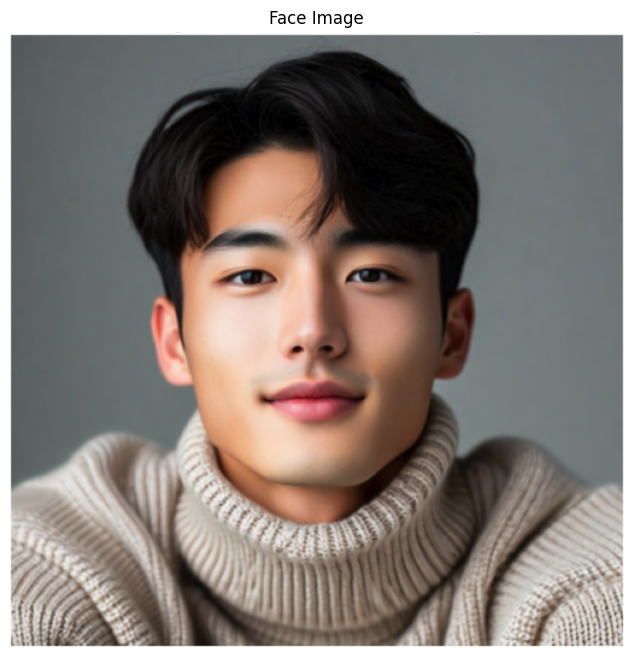

In [61]:
# Set sample image path
image_path = "sample/sample_face.png"

# Load and display image
img = load_and_display_image(image_path)

## Step 1: Face Analysis Function Implementation (Using Nova Model)

In [62]:
def analyze_face(image_path):
    """
    Function to analyze facial features from an image using Nova model
    """
    # Set model ID - Nova Lite model
    model_id = "us.amazon.nova-lite-v1:0"
    
    # Encode image as base64
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    
    # Create Bedrock client
    bedrock_runtime = boto3.client('bedrock-runtime', region_name='us-east-1')
    
    # Create prompt
    system_prompt = "You are an AI specialized in facial analysis. Your role is to analyze facial features and extract key keywords. Do not include any negative content about the face in your output."
    
    user_prompt = """
Please describe the following facial elements of the person in this image in detail within <description> tags:

- Face shape (round, oval, angular, etc.)
- Eye characteristics (size, shape, double eyelids, etc.)
- Nose characteristics (length, shape, bridge height, etc.)
- Lip characteristics (thickness, shape, distinctive features, etc.)
- Skin characteristics (skin tone, distinctive features, etc.)
- Any particularly prominent facial features or expressions
- Hairstyle (length, color, style, etc.)

Also, extract 10 key keywords and list them within <keywords> tags.
"""
    
    try:
        # Set up system prompt
        system_list = [
            {
                "text": system_prompt
            }
        ]
        
        # Set up user message (including image)
        message_list = [
            {
                "role": "user",
                "content": [
                    {
                        "image": {
                            "format": "png",
                            "source": {
                                "bytes": encoded_string
                            }
                        }
                    },
                    {
                        "text": user_prompt
                    }
                ]
            }
        ]
        
        # Set inference parameters
        inf_params = {"maxTokens": 1000, "temperature": 0.3}
        
        # Construct request body
        native_request = {
            "schemaVersion": "messages-v1",
            "messages": message_list,
            "system": system_list,
            "inferenceConfig": inf_params
        }
        
        # Make API request
        response = bedrock_runtime.invoke_model(
            modelId=model_id, 
            body=json.dumps(native_request)
        )
        
        # Process response
        model_response = json.loads(response["body"].read())
        result_text = model_response["output"]["message"]["content"][0]["text"]
        
        print("\nFace Analysis Results:")
        print(result_text)
        
        return result_text

    except ClientError as err:
        message = err.response['Error']['Message']
        logger.error("A client error occurred: %s", message)
        print(f"A client error occured: {message}")
        return None

## Running Face Analysis

In [63]:
# Run face analysis
face_analysis = analyze_face(image_path)


Face Analysis Results:
<description>The individual in the image has a face shape that is best described as oval, with a balanced proportion of width to height. The eyes are almond-shaped with a noticeable double eyelid, giving them a more open and expressive appearance. The nose is straight with a moderate bridge height and a slightly rounded tip, contributing to a harmonious facial balance. The lips are medium thickness with a natural, relaxed smile that highlights their full shape. The skin tone is fair with a smooth texture and no visible blemishes. The individual's hair is short, black, and styled in a sleek, slightly tousled manner that complements the overall look. The expression is friendly and approachable, with a gentle smile that enhances the warmth of the face. The overall appearance is polished and well-groomed.</description>

<keywords>oval face, almond eyes, double eyelids, straight nose, medium lips, fair skin, short hair, friendly expression, sleek hairstyle, polished 

## Step 2: Fortune Generation Function Implementation (Using Nova Model)

In [64]:
def read_face(face_desc):
    """
    Function to generate fortune reading based on facial analysis results using Nova model
    """
    # Set model ID - Nova Lite model
    model_id = "us.amazon.nova-lite-v1:0"
    
    # Create Bedrock client
    bedrock_runtime = boto3.client('bedrock-runtime', region_name='us-east-1')
    
    # Create prompt
    system_prompt = "You are a face reading expert. Your task is to generate a fortune reading based on the provided facial analysis information. Include only positive content in your reading, avoiding any negative interpretations."
    
    user_prompt = f"""
Based on the following facial analysis information, please provide a detailed fortune reading covering these areas:

1. Personality and general fortune based on face shape and overall impression
2. Wisdom and insight based on eye characteristics
3. Wealth and interpersonal relationships based on nose and mouth characteristics
4. Future prospects based on overall facial balance
5. Comprehensive face reading interpretation and advice

Facial Analysis Information:
{face_desc}
"""
    
    try:
        # Set up system prompt
        system_list = [
            {
                "text": system_prompt
            }
        ]
        
        # Set up user message
        message_list = [
            {
                "role": "user",
                "content": [
                    {
                        "text": user_prompt
                    }
                ]
            }
        ]
        
        # Set inference parameters
        inf_params = {"maxTokens": 2000, "temperature": 0.3}
        
        # Construct request body
        native_request = {
            "schemaVersion": "messages-v1",
            "messages": message_list,
            "system": system_list,
            "inferenceConfig": inf_params
        }
        
        # Make API request
        response = bedrock_runtime.invoke_model(
            modelId=model_id, 
            body=json.dumps(native_request)
        )
        
        # Process response
        model_response = json.loads(response["body"].read())
        result_text = model_response["output"]["message"]["content"][0]["text"]
        
        print("\nFortune Reading Results:")
        print(result_text)
        
        return result_text

    except ClientError as err:
        message = err.response['Error']['Message']
        logger.error("A client error occurred: %s", message)
        print(f"A client error occured: {message}")
        return None

## Running Fortune Generation

In [65]:
# Generate fortune reading
fortune = read_face(face_analysis)


Fortune Reading Results:
### Personality and General Fortune Based on Face Shape and Overall Impression

Your oval face shape is often associated with beauty, harmony, and balance, which is beautifully reflected in your overall appearance. This shape is considered highly favorable, suggesting a personality that is adaptable, sociable, and well-rounded. You likely have a warm and approachable demeanor, which makes it easy for others to connect with you. Your balanced proportions and polished look indicate a life filled with positive energy and a general fortune that is stable and prosperous. People around you feel a sense of comfort and trust, which enhances your interpersonal relationships and overall well-being.

### Wisdom and Insight Based on Eye Characteristics

Your almond-shaped eyes with noticeable double eyelids give you an open and expressive appearance, which is a sign of keen insight and wisdom. These eyes suggest that you have a natural ability to perceive deeper truths an

## Organizing and Displaying Results

In [66]:
def display_results(face_analysis, fortune):
    """Function to organize and display analysis results and fortune readings"""
    
    # Generate HTML content
    html_content = f"""
    <div style="margin-bottom: 20px;">
        <h2 style="color: #2E86C1;">📊 Face Analysis Results</h2>
        <div style="background-color: #EBF5FB; padding: 15px; border-radius: 5px; white-space: pre-wrap;">
            {face_analysis}
        </div>
    </div>
    
    <div>
        <h2 style="color: #2E86C1;">🔮 Fortune Reading Results</h2>
        <div style="background-color: #EBF5FB; padding: 15px; border-radius: 5px; white-space: pre-wrap;">
            {fortune}
        </div>
    </div>
    """
    
    # Display HTML
    display(HTML(html_content))

## Displaying Results

In [67]:
# Display results
display_results(face_analysis, fortune)

## Integrated Process Function

In [68]:
def generate_face_fortune(image_path):
    """Integrated function to generate fortune reading from a face image"""
    # Display image
    load_and_display_image(image_path)
    
    # Step 1: Face Analysis
    print("Step 1: Analyzing facial features...")
    face_analysis = analyze_face(image_path)
    
    # Step 2: Fortune Generation
    print("\nStep 2: Generating fortune reading...")
    fortune = read_face(face_analysis)
    
    # Display results
    display_results(face_analysis, fortune)
    
    return face_analysis, fortune

# To test with another image, use the code below
# new_image_path = "sample/another_face.png"  # Another image path
# face_analysis, fortune = generate_face_fortune(new_image_path)